In [1]:
import numpy as np
import imageio
import glob
import math
import matplotlib.pyplot as plt

C:\Users\Hasnain Roopawalla\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Hasnain Roopawalla\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\Hasnain Roopawalla\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def load_mnist():
    # Loads the MNIST dataset from png images

    NUM_LABELS = 10        
    # create list of image objects
    test_images = []
    test_labels = []    
    
    print('Loading Test data..')
    for label in range(NUM_LABELS):
        for image_path in glob.glob("MNIST/Test/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            test_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            test_labels.append(letter)  
    print('Done')        
    # create list of image objects
    train_images = []
    train_labels = []    
    print('Loading Training data..')
    for label in range(NUM_LABELS):
        for image_path in glob.glob("MNIST/Train/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            train_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            train_labels.append(letter)                  
    print('Done')         
    X_train= np.array(train_images).reshape(-1,784)/255.0
    Y_train= np.array(train_labels)
    X_test= np.array(test_images).reshape(-1,784)/255.0
    Y_test= np.array(test_labels)
    
    return X_train, Y_train, X_test, Y_test

In [3]:
X_train, Y_train, X_test, Y_test = load_mnist()
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

Loading Test data..
Done
Loading Training data..
Done
(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [50]:
class FeedForwardNeuralNetwork():
	def __init__(self):
		self.activation_functions_forward_map = {
			'relu': self.relu,
			'sigmoid': self.sigmoid
		}
		self.activation_functions_backward_map = {
			'relu': self.relu_backward,
			'sigmoid': self.sigmoid_backward
		}
		self.weights = []
		self.biases = []
		self.activation_functions = []
		self.num_layers = 0
		self.input_dim = 0


	def add_layer(self, num_nodes, activation_function):
		'''
			param num_nodes: the number of nodes in the layer
			param activation_function: the activation function for the nodes in the layer
			return: append weights and bias matrix to the class weights and biases
		'''
		if activation_function == 'input':
			self.input_dim = num_nodes
		else:
			num_input_weights = self.input_dim if self.num_layers == 0 else self.weights[-1].shape[0]
			w, b = self.initialize_parameters(num_input_weights, num_nodes)
			self.weights.append(w)
			self.biases.append(b)
			self.activation_functions.append(activation_function)
			self.num_layers += 1


	def initialize_parameters(self, num_input_weights, num_nodes):
		'''
			param num_nodes: the number of nodes in the layer
			param num_input_weights: the number of input weights to each node in that layer
			return: weights and bias matrix initialized with random weights (normally distributed)
		'''
		w = []
		b = [0 for j in range(num_nodes)]
		for _ in range(num_nodes):
			node_weights = []
			for _ in range(num_input_weights):
				node_weights.append(np.random.normal(0,0.01))
			w.append(node_weights)
		return np.matrix(w), np.matrix(b)


	def sigmoid(self, weighted_sum):
		'''
			param weighted_sum: the weighted sum (z) calculated by X*w.T + b
			return: sigmoid of each element in the weighted_sum matrix
		'''
		return 1 / (1 + np.exp(-weighted_sum))
		

	def relu(self, weighted_sum):
		'''
			param weighted_sum: the weighted sum (z) calculated by X*w.T + b
			return: relu of each element in the weighted_sum matrix
		'''
		weighted_sum = np.maximum(weighted_sum, 0)
		return weighted_sum


	def linear_forward(self, x, w, b):
		'''
			param x: the inputs to the current layer
			param w: the weights of the current layer
			param b: the bias of the current layer
			return: dot product of input and weights added with the bias 
		'''
		return x.dot(w.T) + b


	def activation_foward(self, weighted_sum, activation_function):
		'''
			param weighted_sum: the weighted sum (z) calculated by X*w.T + b
			param activation_function: the activation function for that layer
			return: the forward activation function as defined for that layer is called
		'''
		return self.activation_functions_forward_map[activation_function](weighted_sum)


	def model_forward(self, x):
		'''
			param x: the inputs to the current layer
			return: linear outputs and activated outputs of all the layers
		'''
		linear_outputs, activation_outputs = [], []
		for layer in range(self.num_layers):
			linear_output = self.linear_forward(x, self.weights[layer], self.biases[layer])
			linear_outputs.append(linear_output)
			activation_output = self.activation_foward(linear_output, self.activation_functions[layer])
			activation_outputs.append(activation_output)
			x = activation_output
		return linear_outputs, activation_outputs
	

	def softmax(self, z):
		'''
			param z: the activated outputs of the last layer
			return: softmax vector for each sample
		'''
		e_x = np.exp(z - np.max(z))
		return e_x / e_x.sum(axis=1)


	def compute_loss(self, softmax_output, true_values):
		'''
			param softmax_output: the activated outputs of the last layer
			param true_values: the actual, true labels (Y)
			return: difference between predicted softmax values and actual values
		'''
		return softmax_output - true_values


	def linear_backward(self, prev_layer_activations, activation_output, activation_function, true_values, is_last_layer, prevdZ, prev_layer_weights):
		'''
			(prev corresponds to the previous layer during the backward phase i.e., previous layer of the current layer is closer to the output)
			param prev_layer_activations: the activated outputs of the previous layer
			param activation_output: the activated outputs of the current layer
			param activation_function: the activation function of the current layer
			param true_values: the actual, true labels (Y)
			param is_last_layer: a boolean indicating if the current layer is the last layer of the network
			param prevdZ: delta Z of the previous layer
			param prev_layer_weights: weights of the previous layer
			return: change in weights, change in bias and delta Z
		'''
		dA = self.activation_backward(activation_output, activation_function)
		if is_last_layer:
			softmax_output = model.softmax(activation_output)
			output_loss = model.compute_loss(softmax_output, true_values)
			dZ = np.multiply(output_loss, dA)
		else:
			dZ = np.multiply(dA, prevdZ.dot(prev_layer_weights))

		dW = dZ.T.dot(prev_layer_activations)
		dB = np.sum(dZ, axis=0)

		return dW, dB, dZ


	def sigmoid_backward(self, activated_output):
		'''
			param activated_output: the activated outputs of that layer
			return: derivative of sigmoid of each element in the activated output matrix
		'''
		return np.multiply(activated_output, (1 - activated_output))
		

	def relu_backward(self, activated_output):
		'''
			param activated_output: the activated outputs of that layer
			return: derivative of relu of each element in the activated_output matrix
		'''
		activated_output[activated_output < 0] = 0
		activated_output[activated_output > 0] = 1
		return activated_output

	
	def activation_backward(self, activated_outputs, activation_function):
		'''
			param activated_outputs: the activated outputs of the current layer
			param activation_function: the activation function for that layer
			return: the backward activation function as defined for that layer is called
		'''
		return self.activation_functions_backward_map[activation_function](activated_outputs)


	def model_backward(self, X_train, Y_train, activation_outputs, lr):
		'''
			param X_train: the training set
			param Y_train: the true labels of the training set
			param activation_outputs: the activation outputs for all layers obtained during forward propagation
			param lr: the learning rate to control the step size
			return: weights and biases are updated for each layer
		'''
		prevdZ = None
		for layer in range(self.num_layers-1, -1, -1):
			prev_layer_activations = X_train if layer == 0 else activation_outputs[layer-1]
			prev_layer_weights = None if layer == self.num_layers - 1 else self.weights[layer+1]
			is_last_layer = True if layer == self.num_layers - 1 else False
			dW, dB, dZ = self.linear_backward(prev_layer_activations, activation_outputs[layer], self.activation_functions[layer], Y_train, is_last_layer, prevdZ, prev_layer_weights)
			prevdZ = dZ
			self.update_parameters(layer, dW, dB, lr)
			
		
	def update_parameters(self, layer, dW, dB, lr):
		'''
			param layer: the index of the current layer
			param dW: the change in weights
			param dB: the change in bias
			param lr: the learning rate to control the step size
			return: update the weights and biases (class variables) of the current layer 
		'''
		self.weights[layer] = self.weights[layer] - lr * dW
		self.biases[layer] = self.biases[layer] - lr * dB
	

	def compute_cost(self, softmax_output, true_values):
		'''
			param softmax_output: the predicted softmax values
			param true_values: the actual, true labels (Y)
			return: cost of the model based on the current weights
		'''
		L = np.log(np.sum(np.exp(softmax_output), axis=1)) - np.sum(np.multiply(true_values,softmax_output), axis=1)
		J = np.sum(L) / true_values.shape[0]
		return J


	def predict(self, X):
		'''
			param X: the input data
			return: softmax values for all samples of the input data
		'''
		_, activation_outputs = self.model_forward(X)
		return model.softmax(activation_outputs[-1])


	def generate_batches(self, X, Y, batch_size):
		'''
			param X: the input data
			param Y: the input labels
			param batch_size: The size of the batch for each iteration
			return: a list of randomly sampled batches (without replacement) 
		'''
		batches = []
		s = np.arange(len(X))
		np.random.shuffle(s)
		for i in range(0,len(s)-batch_size+1,batch_size):
			X_train_mini, Y_train_mini = [], []
			for j in range(i,i+batch_size):
				X_train_mini.append(X[s[j]])
				Y_train_mini.append(Y[s[j]])
			batches.append((np.matrix(X_train_mini),np.matrix(Y_train_mini)))
		return batches


	def train_model(self, X_train, Y_train, X_test, Y_test, lr=0.01, batch_size=1000, epochs=100):
		'''
			param X_train: the input training data
			param Y_train: the input training labels
			param X_test: the test data
			param Y_test: the test labels
			param lr: the learning rate to control the step size
			param batch_size: The size of the batch for each iteration
			param epochs: the number of epochs for traininig
			return: a list training/test data costs and accuracies. The trained weights and biases are class variables and can accessed used directly (no need to return them)
		'''
		train_costs, train_accuracies, test_costs, test_accuracies = [], [], [], []
		for epoch in range(epochs):
			batches = self.generate_batches(X_train, Y_train, batch_size)
			for batch in range(len(batches)):
				X_train_mini, Y_train_mini = batches[batch][0], batches[batch][1]
				linear_outputs, activation_outputs = self.model_forward(X_train_mini)
				self.model_backward(X_train_mini, Y_train_mini, activation_outputs, lr)
				
				pred = self.predict(X_train_mini)
				cost = self.compute_cost(pred, Y_train_mini)
				accuracy = np.mean(np.argmax(pred, axis=1) == np.argmax(np.matrix(Y_train_mini), axis=1))
				train_costs.append(cost)
				train_accuracies.append(accuracy)
				# print('Epoch:', epoch+1, ', Batch:',batch+1, ' -- Train Accuracy:', accuracy, ' Cost:', cost)

			pred = self.predict(X_test)
			cost = self.compute_cost(pred, Y_test)
			accuracy = np.mean(np.argmax(pred, axis=1) == np.argmax(np.matrix(Y_test), axis=1))
			test_costs.append(cost)
			test_accuracies.append(accuracy)
			print('Epoch:', epoch+1, ' -- Test Accuracy:', accuracy, ' Cost:', cost)

		return train_costs, train_accuracies, test_costs, test_accuracies

In [95]:
model = FeedForwardNeuralNetwork()

model.add_layer(num_nodes=784, activation_function='input')
# model.add_layer(num_nodes=128, activation_function='sigmoid')
# model.add_layer(num_nodes=256, activation_function='relu')
model.add_layer(num_nodes=10, activation_function='sigmoid')

train_costs, train_accuracies, test_costs, test_accuracies = model.train_model(X_train, Y_train, X_test, Y_test, lr=0.001, batch_size=1000, epochs=60)

Epoch: 1  -- Test Accuracy: 0.8561  Cost: 2.2211457923161064
Epoch: 2  -- Test Accuracy: 0.8696  Cost: 2.2122481217850627
Epoch: 3  -- Test Accuracy: 0.8742  Cost: 2.2079892255508273
Epoch: 4  -- Test Accuracy: 0.8786  Cost: 2.205339473659524
Epoch: 5  -- Test Accuracy: 0.8817  Cost: 2.2035025475914867
Epoch: 6  -- Test Accuracy: 0.8835  Cost: 2.2020691234903786
Epoch: 7  -- Test Accuracy: 0.8869  Cost: 2.2010093130149837
Epoch: 8  -- Test Accuracy: 0.8881  Cost: 2.200151043765728
Epoch: 9  -- Test Accuracy: 0.8891  Cost: 2.199385739083626
Epoch: 10  -- Test Accuracy: 0.891  Cost: 2.198738327921036
Epoch: 11  -- Test Accuracy: 0.8921  Cost: 2.1981908472830316
Epoch: 12  -- Test Accuracy: 0.893  Cost: 2.1977338576934615
Epoch: 13  -- Test Accuracy: 0.8949  Cost: 2.1973204778479825
Epoch: 14  -- Test Accuracy: 0.895  Cost: 2.196927722771601
Epoch: 15  -- Test Accuracy: 0.8962  Cost: 2.1966230562618985
Epoch: 16  -- Test Accuracy: 0.8971  Cost: 2.196272833256833
Epoch: 17  -- Test Accurac

Test Accuracy: 0.9111
2.1907656866319294
2.1907656866319294


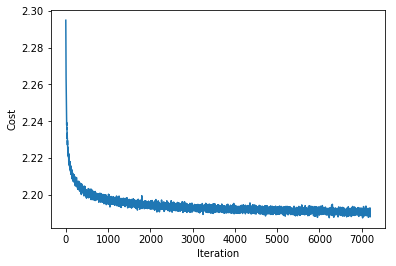

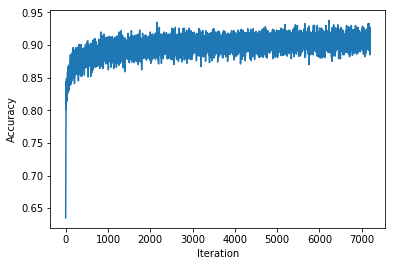

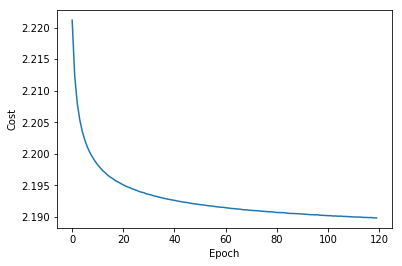

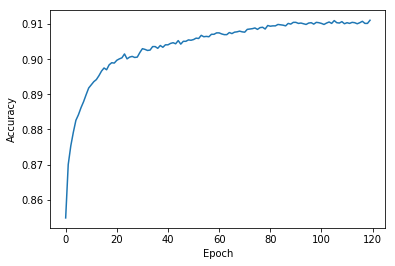

In [47]:
pred = model.predict(X_test)
print('Test Accuracy:',np.mean(np.argmax(pred, axis=1) == np.argmax(np.matrix(Y_test), axis=1)))

print(train_costs[-1])
print(train_costs[-1])
plt.plot(train_costs)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

plt.plot(train_accuracies,label='Training Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()

plt.plot(test_costs,label='Test Costs')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

plt.plot(test_accuracies,label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

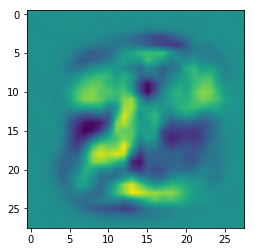

In [96]:
# w = np.array(model.weights[0])
fig = plt.figure()
layer = model.weights[0][8]

W_reshaped = np.reshape(layer, (28, 28))
ax1 = fig.add_subplot(1,1,1)

ax1.imshow(W_reshaped, interpolation='bilinear')

plt.show()